# Lambertian Photometric Stereo

For the purposes of this project, I will implement Lambertian Photometric stereo. As an input, my program takes in multiple images along with the light source direction for each image. These images are provided by Satya Mallick.

Keys: dict_keys(['__version__', 'l4', '__header__', 'im1', 'im3', 'im2', 'l2', 'im4', 'l1', '__globals__', 'l3'])
Image:


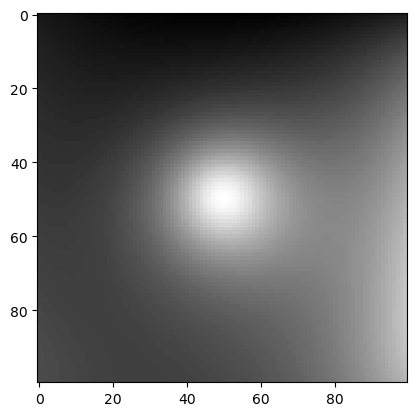

Light source direction: [[0 0 1]]


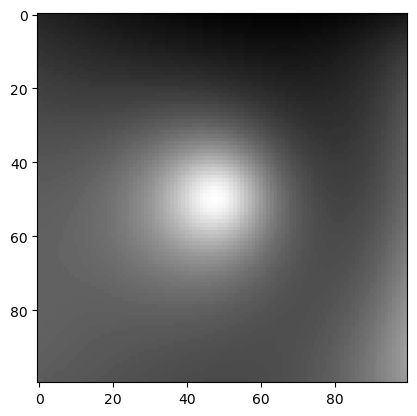

Light source direction: [[0.2 0.  1. ]]


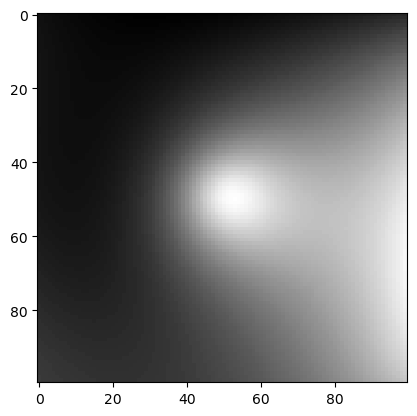

Light source direction: [[-0.2  0.   1. ]]


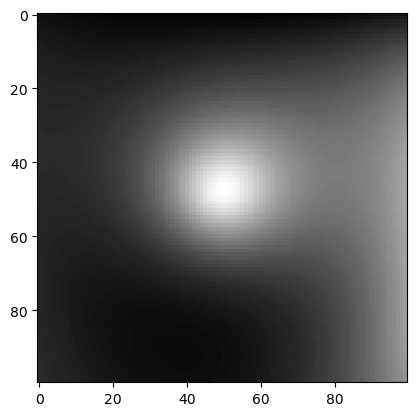

Light source direction: [[0.  0.2 1. ]]


In [4]:
## Code to read data in provided by Manmohan Chandraker

import pickle
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
pickle_in = open("synthetic_data.pickle", "rb")
data = pickle.load(pickle_in, encoding="latin1")

print("Keys: " + str(data.keys()))

print("Image:")
plt.imshow(data["im1"], cmap = "gray")
plt.show()

print("Light source direction: " + str(data["l1"]))

plt.imshow(data["im2"], cmap = "gray")
plt.show()

print("Light source direction: " + str(data["l2"]))

plt.imshow(data["im3"], cmap = "gray")
plt.show()

print("Light source direction: " + str(data["l3"]))

plt.imshow(data["im4"], cmap = "gray")
plt.show()

print("Light source direction: " + str(data["l4"]))

In [5]:
import numpy as np
from scipy.signal import convolve
from numpy import linalg

# Function to horn integrate provided by Manmohan Chandraker
def horn_integrate(gx, gy, mask, niter):
    """
    horn_integrate recovers the function g from its partial 
    derivatives gx and gy. 
    mask is a binary image which tells which pixels are 
    involved in integration. 
    niter is the number of iterations. 
    typically 100,000 or 200,000, 
    although the trend can be seen even after 1000 iterations.
    """
    g = np.ones(np.shape(gx))
    
    gx = np.multiply(gx, mask)
    gy = np.multiply(gy, mask)
    
    A = np.array([[0,1,0],[0,0,0],[0,0,0]]) #y-1
    B = np.array([[0,0,0],[1,0,0],[0,0,0]]) #x-1
    C = np.array([[0,0,0],[0,0,1],[0,0,0]]) #x+1
    D = np.array([[0,0,0],[0,0,0],[0,1,0]]) #y+1
    
    d_mask = A + B + C + D
    
    den = np.multiply(convolve(mask,d_mask,mode="same"),mask)
    den[den == 0] = 1
    rden = 1.0 / den
    mask2 = np.multiply(rden, mask)
    
    m_a = convolve(mask, A, mode="same")
    m_b = convolve(mask, B, mode="same")
    m_c = convolve(mask, C, mode="same")
    m_d = convolve(mask, D, mode="same")
    
    term_right = np.multiply(m_c, gx) + np.multiply(m_d, gy)
    t_a = -1.0 * convolve(gx, B, mode="same")
    t_b = -1.0 * convolve(gy, A, mode="same")
    term_right = term_right + t_a + t_b
    term_right = np.multiply(mask2, term_right)
    
    for k in range(niter):
        g = np.multiply(mask2, convolve(g, d_mask, mode="same")) + term_right
    
    return g

### Implementation of Photometric Stereo function

This function will be the main function used for photometric stereo. It takes in images, locations of the lights used, and a mask, and conducts photometric stereo.

In [6]:
def photometric_stereo(images, lights, mask, horn_niter=25000):

    # note:
    # images : (n_ims, h, w)
    # lights : (n_ims, 3)
    # mask   : (h, w)
    
    albedo = np.ones(images[0].shape)
    normals = np.dstack((np.zeros(images[0].shape),
                         np.zeros(images[0].shape),
                         np.ones(images[0].shape)))

    H_horn = np.ones(images[0].shape)

    if len(images) == 3:
        # reading the images in
        im1 = images[0]
        im2 = images[1]
        im3 = images[2]
    
        # reading in light source direction
        light1 = lights[0]
        light2 = lights[1]
        light3 = lights[2]
        s = np.array(lights)
        invS = np.linalg.inv(s)
    
        for imLen1 in range(0,len(im1)):
            for imLen2 in range(0,len(im1[0])):
                i = np.array([im1[imLen1][imLen2], im2[imLen1][imLen2], im3[imLen1][imLen2]])
                b = np.dot(invS,i)
                alb = np.linalg.norm(b)
                albedo[imLen1,imLen2] = alb
                surfNorms = np.divide(b,alb)
                normals[imLen1,imLen2] = surfNorms
    
        n1 = np.zeros(images[1].shape)
        for imLen1 in range(0,len(im1)):
            for imLen2 in range(0,len(im1[0])):
                n1[imLen1,imLen2] = normals[imLen1,imLen2,0]
    
        n2 = np.zeros(images[1].shape)
        for imLen1 in range(0,len(im1)):
            for imLen2 in range(0,len(im1[0])):
                n2[imLen1,imLen2] = normals[imLen1,imLen2,1]
    
        n3 = np.zeros(images[1].shape)
        for imLen1 in range(0,len(im1)):
            for imLen2 in range(0,len(im1[0])):
                n3[imLen1,imLen2] = normals[imLen1,imLen2,2]
    
        dx = np.divide(n1,n3)
        dy = np.divide(n2,n3)
        H_horn = horn_integrate(dx, dy, mask, horn_niter)

    if len(images) == 4:
        # reading the images in
        im1 = images[0]
        im2 = images[1]
        im3 = images[2]
        im4 = images[3]
    
        # reading in light source direction
        light1 = lights[0]
        light2 = lights[1]
        light3 = lights[2]
        light4 = lights[3]
        s = np.array(lights)
        s_T = np.transpose(s)
        s1 = np.dot(s_T, s)
        pseudoInvS = np.linalg.inv(s1)
    
        for imLen1 in range(0,len(im1)):
            for imLen2 in range(0,len(im1[0])):
                i = np.array([im1[imLen1][imLen2], im2[imLen1][imLen2], im3[imLen1][imLen2], im4[imLen1][imLen2]])
                b1 = np.dot(s_T,i)
                b = np.dot(pseudoInvS, b1)
                alb = np.linalg.norm(b)
                albedo[imLen1,imLen2] = alb
                surfNorms = np.divide(b,alb)
                normals[imLen1,imLen2] = surfNorms
    
        n1 = np.zeros(images[1].shape)
        for imLen1 in range(0,len(im1)):
            for imLen2 in range(0,len(im1[0])):
                n1[imLen1,imLen2] = normals[imLen1,imLen2,0]
    
        n2 = np.zeros(images[1].shape)
        for imLen1 in range(0,len(im1)):
            for imLen2 in range(0,len(im1[0])):
                n2[imLen1,imLen2] = normals[imLen1,imLen2,1]
    
        n3 = np.zeros(images[1].shape)
        for imLen1 in range(0,len(im1)):
            for imLen2 in range(0,len(im1[0])):
                n3[imLen1,imLen2] = normals[imLen1,imLen2,2]
    
        dx = np.divide(n1,n3)
        dy = np.divide(n2,n3)
        H_horn = horn_integrate(dx, dy, mask, horn_niter)

    
    return albedo, normals, H_horn

### Displaying Photometric Stereo

Here, we display the outputs using three images that we feed into our previously coded photometric stereo function. We show the estimated albedo map, the estimated surface normals, and the wireframe of the depth map.

In [7]:
from mpl_toolkits.mplot3d import Axes3D

def visualize(albedo, normals, horn_depth):
    # Stride in the plot, you may want to adjust it to different images
    stride = 15

    # showing albedo map
    fig = plt.figure()
    albedo_max = albedo.max()
    albedo = albedo / albedo_max
    plt.imshow(albedo, cmap="gray")
    plt.show()

    # showing normals as three separate channels
    figure = plt.figure()
    ax1 = figure.add_subplot(131)
    ax1.imshow(normals[..., 0])
    ax2 = figure.add_subplot(132)
    ax2.imshow(normals[..., 1])
    ax3 = figure.add_subplot(133)
    ax3.imshow(normals[..., 2])
    plt.show()

    # showing normals as quiver
    X, Y, _ = np.meshgrid(np.arange(0,np.shape(normals)[0], 15),
                          np.arange(0,np.shape(normals)[1], 15),
                          np.arange(1))
    X = X[..., 0]
    Y = Y[..., 0]
    Z = horn_depth[::stride,::stride].T
    NX = normals[..., 0][::stride,::-stride].T
    NY = normals[..., 1][::-stride,::stride].T
    NZ = normals[..., 2][::stride,::stride].T
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(projection='3d')
    plt.quiver(Y,X,Z,NX,NY,NZ, length=10)
    plt.show()

    # plotting wireframe depth map

    H = horn_depth[::stride,::stride]
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.plot_surface(X,Y, H.T)
    plt.show()

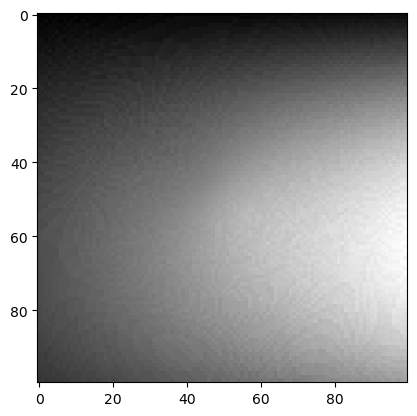

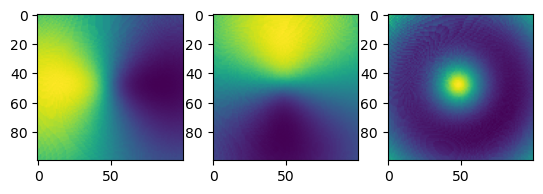

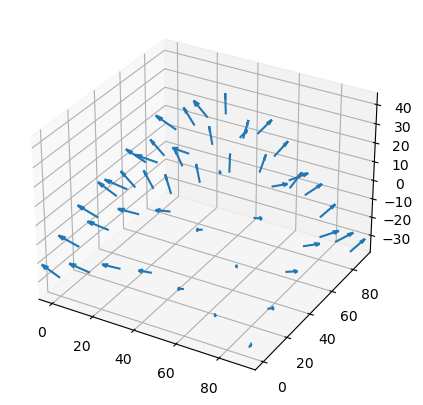

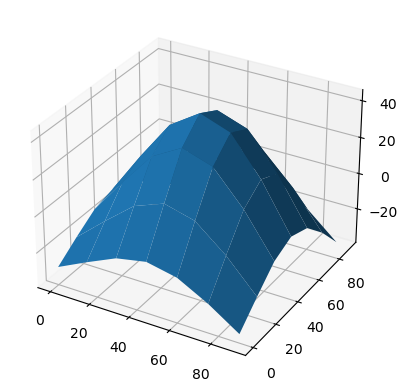

In [8]:
pickle_in = open("synthetic_data.pickle", "rb")
data = pickle.load(pickle_in, encoding="latin1")

lights = np.vstack((data["l1"], data["l2"], data["l4"]))

images = []
images.append(data["im1"])
images.append(data["im2"])
images.append(data["im4"])
images = np.array(images)

mask = np.ones(data["im1"].shape)

albedo, normals, horn_depth = photometric_stereo(images, lights, mask)

visualize(albedo, normals, horn_depth)

Here, we adapt the code above to use the function for four images, to get a more accurate visualization for photometric stereo.

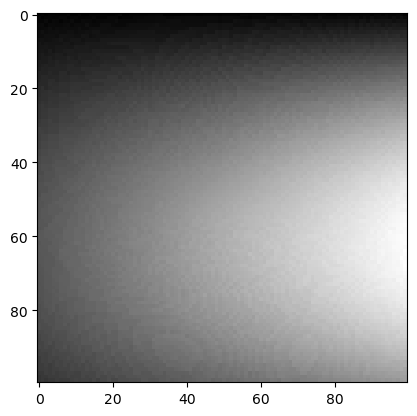

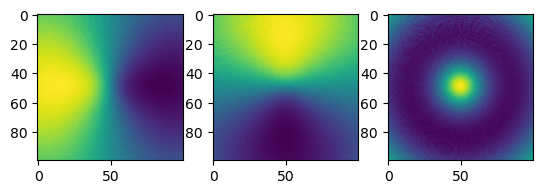

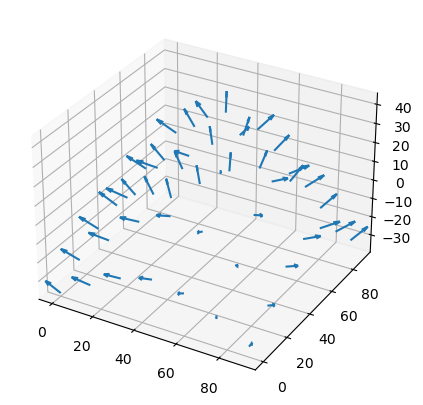

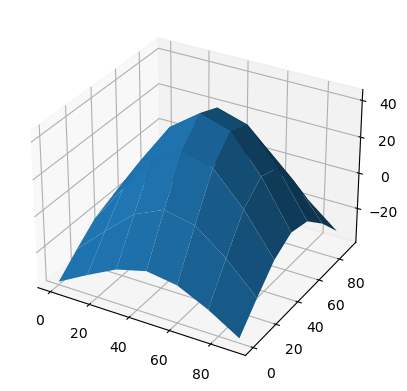

In [9]:
pickle_in = open("synthetic_data.pickle", "rb")
data = pickle.load(pickle_in, encoding="latin1")

lights = np.vstack((data["l1"], data["l2"], data["l3"], data["l4"]))

images = []
images.append(data["im1"])
images.append(data["im2"])
images.append(data["im3"])
images.append(data["im4"])
images = np.array(images)

mask = np.ones(data["im1"].shape)

albedo, normals, horn_depth = photometric_stereo(images, lights, mask)

visualize(albedo, normals, horn_depth)
